In [35]:
import numpy as np
import pandas as pd
import matplotlib as mp
import statsmodels.api as sm

from statsmodels.sandbox.regression.gmm import IV2SLS 
# There is a package named IV2SLS in Python. Do not use this package! The exogenous explanatory variables must
# be entered as instruments. So it gives wrong answers
from statsmodels.sandbox.regression.gmm import GMM


In [36]:
data = pd.read_csv('/Users/huiyisang/Desktop/midterm_partone.csv')

In [37]:
data.head()

,Constant,Stock Change,Inventory Turnover,Operating Profit,Interaction Effect,Current Ratio,Quick Ratio,Debt Asset Ratio
0,1,0.870332,1.795946,0.115846,0.208053,1.672527,0.255171,0.473317
1,1,-0.047347,1.395501,0.436967,0.609788,1.637261,0.221763,0.489967
2,1,0.001176,1.664563,0.541016,0.900555,1.640619,0.189141,0.374269
3,1,-0.901200,1.605738,0.539399,0.866133,1.436221,0.131944,0.224399
4,1,-0.176353,1.591451,0.539938,0.859285,1.433140,0.183095,0.213446


In [38]:
model_iv = sm.OLS(data["Inventory Turnover"],data[["Constant","Current Ratio","Quick Ratio",\
                                                                 "Debt Asset Ratio"]]).fit()

endog_predict = model_iv.predict(data[["Constant","Current Ratio","Quick Ratio","Debt Asset Ratio"]])
data["Endogenous Param"] = endog_predict

In [39]:
model_2sls = sm.OLS(data["Stock Change"], data[["Constant","Endogenous Param",\
                                                              "Operating Profit","Interaction Effect",\
                                                             ]]).fit()
print(model_2sls.summary())

                            OLS Regression Results                            
Dep. Variable:           Stock Change   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     8.530
Date:                Thu, 07 Nov 2024   Prob (F-statistic):           1.27e-05
Time:                        01:01:32   Log-Likelihood:                -1186.5
No. Observations:                1696   AIC:                             2381.
Df Residuals:                    1692   BIC:                             2403.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Constant              -0.0176      0

In [40]:
data

,Constant,Stock Change,Inventory Turnover,Operating Profit,Interaction Effect,Current Ratio,Quick Ratio,Debt Asset Ratio,Endogenous Param
0,1,0.870332,1.795946,0.115846,0.208053,1.672527,0.255171,0.473317,10.724599
1,1,-0.047347,1.395501,0.436967,0.609788,1.637261,0.221763,0.489967,10.812673
2,1,0.001176,1.664563,0.541016,0.900555,1.640619,0.189141,0.374269,9.001338
3,1,-0.901200,1.605738,0.539399,0.866133,1.436221,0.131944,0.224399,11.995705
4,1,-0.176353,1.591451,0.539938,0.859285,1.433140,0.183095,0.213446,13.536649
...,...,...,...,...,...,...,...,...,...
1691,1,-0.015543,5.225766,0.309119,1.615384,3.554503,2.197871,0.005549,13.504958
1692,1,0.399089,5.324390,0.274782,1.463044,3.745006,2.324502,0.004359,11.994641
1693,1,-0.702200,5.575258,0.287503,1.602905,3.434909,2.282626,0.000000,19.312977
1694,1,0.283926,5.423463,0.256657,1.391968,2.876645,1.454948,0.000000,10.094274


PART 1

In [41]:
y_vals = np.array(data["Stock Change"])
x_vals = np.array(data[["Inventory Turnover", "Operating Profit", "Interaction Effect"]])
iv_vals = np.array(data[["Current Ratio", "Quick Ratio", "Debt Asset Ratio"]])

class gmm_with_vector_bias(GMM):
    def momcond(self, params):
        # Unpack parameters
        p0, p1, p2, p3, p4 = params  # Include p4 as the additional parameter
        endog = self.endog
        exog = self.exog
        inst = self.instrument
        
        # Define the moment conditions with p4 bias term applied to a 1*3 vector [1, 1, 1]
        bias_vector = np.array([1, 1, 1])
        residuals = endog - (p0 + p1 * exog[:, 0] + p2 * exog[:, 1] + p3 * exog[:, 2])
        
        error0 = (residuals - p4 * bias_vector[0]) * exog[:, 0]
        error1 = (residuals - p4 * bias_vector[1]) * exog[:, 1]
        error2 = (residuals - p4 * bias_vector[2]) * exog[:, 2]
        error3 = (residuals - p4 * bias_vector[0]) * inst[:, 0]
        error4 = (residuals - p4 * bias_vector[1]) * inst[:, 1]
        error5 = (residuals - p4 * bias_vector[2]) * inst[:, 2]
        
        g = np.column_stack((error0, error1, error2, error3, error4, error5))
        return g

beta_with_p4 = np.array([0.1, 0.1, 0.1, 0.1, 0.1]) 

# Fit the modified GMM model
res = gmm_with_vector_bias(endog=y_vals, exog=x_vals, instrument=iv_vals, k_moms=6, k_params=5).fit(beta_with_p4)
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 5
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000383
         Iterations: 6
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000381
         Iterations: 6
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000381
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
                          gmm_with_vector_bias Results                          
Dep. Variable:                        y   Hansen J:                       0.6466
Model:             gmm_with_vector_bias   Prob (Hansen J):                 0.421
Method:                             GMM                                    



Since 𝛿 has a high p-value (1.000), we would conclude that there is no statistically significant bias as claimed by the industry expert. This outcome suggests that the hypothesis of bias in the moment conditions may not be supported by the data.

PART 2

In [42]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import classification_report,f1_score, PrecisionRecallDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix

In [43]:
df = pd.read_csv('/Users/huiyisang/Desktop/midterm_parttwo.csv')

In [44]:
df.head()

,Years of Education after High School,Requested Credit Amount,Number of Dependents,Monthly Income,Monthly Expense,Marital Status,Credit Rating
0,1,Low,No dependent,Very low,Very low,Married,Positive
1,2,Low,No dependent,Very low,Very low,Single,Positive
2,1,Low,No dependent,Very low,Very low,Single,Positive
3,3,Low,No dependent,Very low,Very low,Married,Positive
4,3,Low,No dependent,Very low,Very low,Single,Negative


In [45]:
categorical_columns = ['Requested Credit Amount','Number of Dependents', 'Monthly Income', 'Monthly Expense','Marital Status']

label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [46]:
df['Credit Rating'] = df['Credit Rating'].replace({"Positive": 1 , "Negative": 0})

/var/folders/hj/50ynckj97xq7d49_2_s66f100000gn/T/ipykernel_84855/633102746.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Credit Rating'] = df['Credit Rating'].replace({"Positive": 1 , "Negative": 0})


In [47]:
df

,Years of Education after High School,Requested Credit Amount,Number of Dependents,Monthly Income,Monthly Expense,Marital Status,Credit Rating
0,1,1,2,4,4,0,1
1,2,1,2,4,4,2,1
2,1,1,2,4,4,2,1
3,3,1,2,4,4,0,1
4,3,1,2,4,4,2,0
...,...,...,...,...,...,...,...
8076,3,1,0,3,3,0,1
8077,3,2,0,3,3,0,0
8078,3,2,1,3,3,0,1
8079,7,2,0,3,3,0,1


In [48]:
df.columns

Index(['Years of Education after High School', 'Requested Credit Amount',
       'Number of Dependents', 'Monthly Income', 'Monthly Expense',
       'Marital Status', 'Credit Rating'],
      dtype='object')

In [49]:
scaler = MinMaxScaler()

columns_to_scale = df.columns.difference(['Credit Rating'])
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [50]:
X = df.drop(columns=['Credit Rating'])
y = df['Credit Rating']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE()
X_res, y_res = smote.fit_resample(X_train, y_train)

In [51]:
logreg = LogisticRegression()

In [52]:
lr_model = logreg.fit(X_train,y_train)

pred_log = lr_model.predict(X_test)

In [53]:
print(f'Logistic Regression F1 Score: {f1_score(y_test, pred_log)}')
print(f'Logistic Regression Precision Score: {precision_score(y_test, pred_log)}')
print(f'Logistic Regression Recall Score: {recall_score(y_test, pred_log)}')

Logistic Regression F1 Score: 0.9231179213857429
Logistic Regression Precision Score: 0.8572135609997525
Logistic Regression Recall Score: 1.0


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

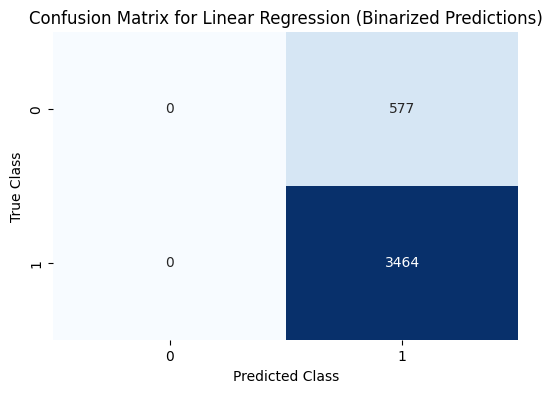

In [55]:
#Confusion Matrix
cm_log = confusion_matrix(y_test, pred_log)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix for Linear Regression (Binarized Predictions)")
plt.show()

part 2 - b

In [56]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, test_size=0.15, random_state=42)

In [ ]:
X_res1, y_res1 = smote.fit_resample(X_train1, y_train1)

In [57]:
lr_model1 = logreg.fit(X_train1, y_train1)

pred_log1 = lr_model.predict(X_test1)

In [58]:
print(f'Logistic Regression F1 Score: {f1_score(y_test1, pred_log1)}')
print(f'Logistic Regression Precision Score: {precision_score(y_test1, pred_log1)}')
print(f'Logistic Regression Recall Score: {recall_score(y_test1, pred_log1)}')

Logistic Regression F1 Score: 0.9265486725663716
Logistic Regression Precision Score: 0.8631492168178071
Logistic Regression Recall Score: 1.0


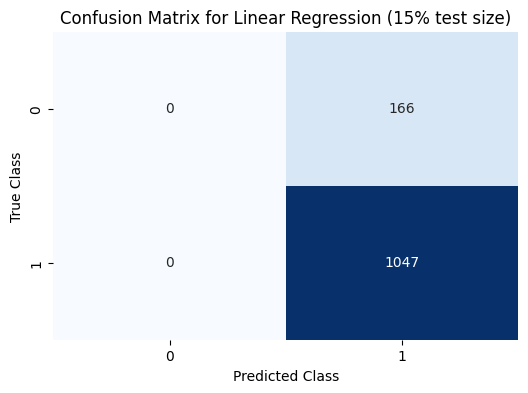

In [61]:
#Confusion Matrix
cm_log1 = confusion_matrix(y_test1, pred_log1)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix for Linear Regression (15% test size)")
plt.show()